# ProWave - WaveNet-based Protein Generation

Authors: Hans Jakob Damsgaard & Lucas Balling

02456 Deep Learning project: ProGen

## Initialization

Run the commmand below if you have not yet installed the [TAPE project](https://github.com/songlab-cal/tape).

In [2]:
#!pip install tape_proteins

#### Importing needed packages

In [53]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import tape

#### Importing the data

We were unable to make the data download script, `download_data.sh`, run from Jupyter, so instead we ran it manually and simply placed the resulting files in the right folder for TAPE to find them. We import all the data in the LMDB format as it is most easily worked with in Python.

In [59]:
from tape.datasets import LanguageModelingDataset

data_path = '/Users/lucasballing/Desktop/DeepLearningProject/prowave-main/data/pfam/'
#data_path = 'E:/Pfam/data/'
#train_data   = LanguageModelingDataset(data_path, 'train')
#valid_data   = LanguageModelingDataset(data_path, 'valid')
#holdout_data = LanguageModelingDataset(data_path, 'holdout')

#### Understanding data features

To get a good understanding of the data provided in the imported dataset, we provide plots of certain features and their ranges. Data is already split into the three required subsets; train, validation, and holdout by TAPE, so it is also interesting to understand this split.

In [5]:
# Split sizes
print(f'Training data has shape ({len(train_data)}, {len(train_data[0])})')
print(f'Validation data has shape ({len(valid_data)}, {len(valid_data[0])})')
print(f'Holdout data has shape ({len(holdout_data)}, {len(holdout_data[0])})')

# Original data columns
from tape.datasets import LMDBDataset
lmdb_train = LMDBDataset(data_path+'pfam/pfam_train.lmdb')
print(f'File data entries look like this: {lmdb_train[0]}')
del lmdb_train

# Data columns - all subsets are taken from the same overall dataset, so the columns are the same
# From combining information from LMDBDataset and LanguageModelingDataset, we know the columns are
# - IUPAC-encoded protein string
# - Input mask (for masked-token prediction)
# - Protein clan
# - Protein family
# The protein ID (i.e., its number within its clan and family) is not included
print(f'Encoded data entries look like this: {train_data[0]}')
del train_data
del valid_data
del holdout_data

Training data has shape (32593668, 4)
Validation data has shape (1715454, 4)
Holdout data has shape (44311, 4)
File data entries look like this: {'primary': 'GCTVEDRCLIGMGAILLNGCVIGSGSLVAAGALITQ', 'protein_length': 36, 'clan': 433, 'family': 9122, 'id': '0'}
Encoded data entries look like this: (array([ 2, 11,  7, 23, 25,  9,  8, 21,  7, 15, 13, 11, 16, 11,  5, 13, 15,
       15, 17, 11,  7, 25, 13, 11, 22, 11, 22, 15, 25,  5,  5, 11,  5, 15,
       13, 23, 20,  3], dtype=int64), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64), 433, 9122)


In [6]:
#from utils import setify

# Fetch results from all splits
#results = setify([train_data, valid_data, holdout_data])

# Clans in splits
#clans = results[0][0]
#print(f'Unique clans in training data {len(clans[0])}')
#print(f'Unique clans in validation data {len(clans[1])}')
#print(f'Unique clans in holdout data {len(clans[2])}')

# Families in splits
#families = results[0][1]
#print(f'Unique families in training data {len(families[0])}')
#print(f'Unique families in validation data {len(families[1])}')
#print(f'Unique families in holdout data {len(families[2])}')

# PRINTS:
# Unique clans in training data 623
# Unique clans in validation data 623
# Unique clans in holdout data 8
# Unique families in training data 17737
# Unique families in validation data 15974
# Unique families in holdout data 28

# Idea and Initial Implementation
We intend to follow the ideas presented in the ProGen paper relatively closely. That is, our network will be trained on conditioned aminoacid sequences with the only two available conditioning tags being the clan and family IDs. To enable this, our network's input will be as shown on the figure below.

<img src="../Training.png" width="500"/>

So, like ProGen, our input $x=[c;a]$ is a sequence of encoded conditioning tags $c=(c_0,...,c_n)$ (in this case just two), and a starting sequence $a=(a_0, ..., a_n)$ of aminoacids for starting the sequence generation. The sequence is fed one character at a time to the network, which accumulates state before starting generation. We intend to let the network run free either until it generates an end character or until the generated sequence has length 500.


## One-hot encoding
One way to represent a fixed amount of words is through one-hot encoding. We intend to use one-hot encoding for both aminoacids as well as conditioning tags meaning that the input characters to our network become rather large. This may seem inefficient due to the great sparsity in the vectors produced, but we intend to limit this sparsity by decreasing the number of clans and families considered. This will allow us to generate proteins only for a subset of the available clans and families but at a much shorter required training and evaluation time. 

An example of a one-hot encoding is shown below:

| Amionacid    | one-hot encoded vector   |
| ------------- |--------------------------|
| pad   | $= [0, 0, 0, \ldots, 0]$ |
| CLS   | $= [0, 1, 0, \ldots, 0]$ |
| SEP   | $= [0, 0, 1, \ldots, 0]$ | 
| Ala = A  | $= [0, 0, 0, 1, 0, \ldots, 0]$ |
| Asx = B  | $= [0, 0, 0, 0, 1,\ldots, 0]$ |
| ... | ... |

This notebook will as tape use the BERT sequence  [CLS] X [SEP] - Start and stop sequences.

Although the implementation from earlier in the course, which is used below, works well, we have decided to instead use Pytorch's own Embedding module which allows us to skip manually encoding vectors.

For more information about the one hot incoding see the TAPE: https://github.com/songlab-cal/tape/blob/master/tape/tokenizers.py

In [55]:
from utils import one_hot_encode, one_hot_encode_sequence

# Testing the implementation
VOCAB_SIZE = 30
#test_word = one_hot_encode(1,VOCAB_SIZE)
#print(f'Our one-hot encoding of \'1\' has shape {test_word.shape}.')
#print(test_word)

#test_sentence = one_hot_encode_sequence(holdout_data[1][0], VOCAB_SIZE)
#print(f'Our one-hot encoding of \'{holdout_data[1][0]}\' has shape {test_sentence.shape}.')
#print(test_sentence)

## Reducing input size
To reduce training time and problem size, we intend to extract 10 clans and their families from the training set and use those for training the network. Data is stored in sorted order in the training data set meaning that we can simply store elements until we see the 11th clan ID at which we can stop looking through the dataset. This is preferable over having to look through the entire dataset (as we did to gather plot data earlier), as such an operation takes a long time due to the mere size of the dataset.

As part of this operation, we also throw away the input masks that are included in the original dataset and attempt to limit data size by using `int8` instead of the original `int64` format for encoded sequences.

In [56]:
CLANS = 10
FAMILIES = 100
LENGTH = 512

In [57]:
# Reduce data size by picking only 10 first clans
#from utils import get_data
#for d, n in zip([train_data, valid_data, holdout_data], ['train', 'valid', 'holdout']):
#    dataset = get_data(d, CLANS)
#    with open(data_path+n+'_red.pkl', 'wb') as f:
#        pkl.dump(dataset, f)
#    del dataset

In [60]:
# Reduce data size by picking only the 100 first families
#for i, o in zip(['train_red.pkl', 'valid_red.pkl', 'holdout_red.pkl'], ['train_red2.pkl', 'valid_red2.pkl', #'holdout_red2.pkl']):
#    # Load reduced dataset
#    with open(data_path+i, 'rb') as fin:
#        dataset = pkl.load(fin)
#    # Reduce number of families
#    dataset = dataset[dataset['Family ID'].isin(list(range(FAMILIES)))]
#    # Store reduced data
#    with open(data_path+o, 'wb') as fout:
#        pkl.dump(dataset, fout)
#    del dataset

# Use the reduced dataset
with open(data_path+'train_red2.pkl', 'rb') as f:
    train_data = pkl.load(f)
with open(data_path+'valid_red2.pkl', 'rb') as f:
    valid_data = pkl.load(f)

Running the above code reduces the overall data size to around 50 MB training data, 2.5 MB validation data, and unfortunately no holdout data. We shall now plot some characteristics of the training data:

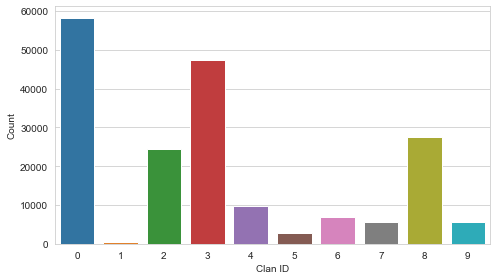

In [61]:
# Plot the number of proteins in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(train_data[train_data['Clan ID']==i]) for i in range(CLANS)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

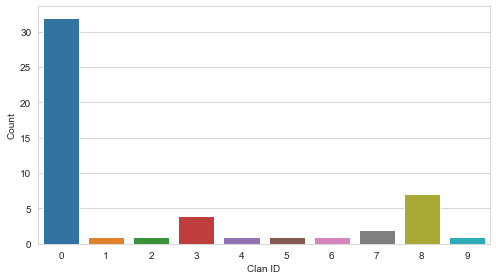

In [62]:
# Plot the number of families in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(set(train_data[train_data['Clan ID']==i]['Family ID'])) for i in range(CLANS)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

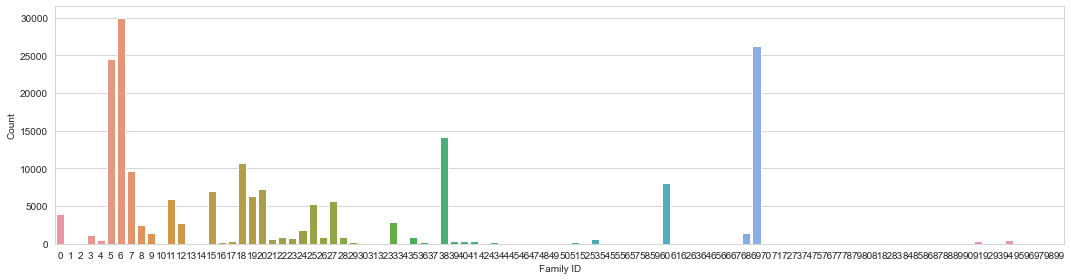

In [63]:
# Plot the number of proteins in each family
pdf = pd.DataFrame.from_dict({'Family ID' : list(range(FAMILIES)),'Count' : [len(train_data[train_data['Family ID']==i]) for i in range(FAMILIES)]})
plt.figure(figsize=(15,4))
sns.barplot(x='Family ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

In [64]:
# Print some information about the data
print(train_data.info())
print(train_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188963 entries, 5 to 10396718
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sequence   188963 non-null  object
 1   Clan ID    188963 non-null  int64 
 2   Family ID  188963 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.8+ MB
None
                                              Sequence  Clan ID  Family ID
5    [2, 16, 12, 25, 20, 21, 28, 9, 25, 11, 16, 9, ...        8         20
14   [2, 19, 19, 9, 5, 25, 22, 20, 15, 13, 25, 21, ...        7         25
148  [2, 5, 15, 20, 23, 5, 8, 21, 8, 11, 25, 22, 7,...        0          0
177  [2, 22, 15, 15, 5, 23, 8, 14, 28, 22, 25, 17, ...        0          0
185  [2, 21, 8, 15, 9, 25, 26, 20, 21, 5, 16, 9, 20...        0         11


And repeat this for the validation data.

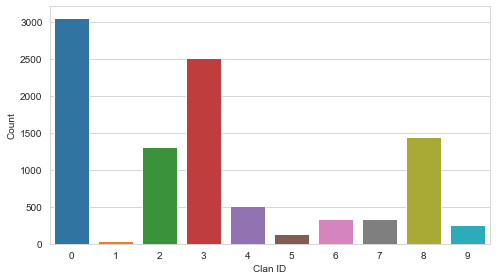

In [65]:
# Plot the number of proteins in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(valid_data[valid_data['Clan ID']==i]) for i in range(CLANS)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

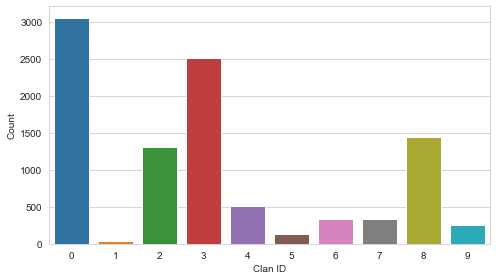

In [16]:
# Plot the number of proteins in each clan
pdf = pd.DataFrame.from_dict({'Clan ID' : list(range(CLANS)),'Count' : [len(valid_data[valid_data['Clan ID']==i]) for i in range(CLANS)]})
plt.figure(figsize=(7,4))
sns.barplot(x='Clan ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

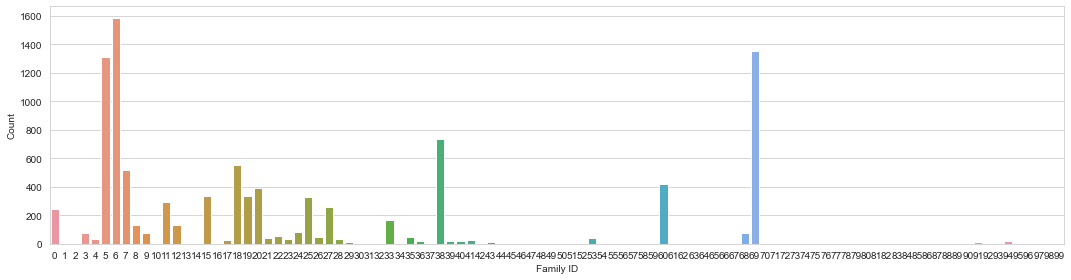

In [66]:
# Plot the number of proteins in each family
pdf = pd.DataFrame.from_dict({'Family ID' : list(range(FAMILIES)),'Count' : [len(valid_data[valid_data['Family ID']==i]) for i in range(FAMILIES)]})
plt.figure(figsize=(15,4))
sns.barplot(x='Family ID', y='Count', data=pdf)
plt.tight_layout()
plt.show()

In [67]:
# Print some information about the data
print(valid_data.info())
print(valid_data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9946 entries, 83 to 547095
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sequence   9946 non-null   object
 1   Clan ID    9946 non-null   int64 
 2   Family ID  9946 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 310.8+ KB
None
                                              Sequence  Clan ID  Family ID
83   [2, 15, 23, 20, 23, 15, 21, 15, 15, 12, 28, 19...        8         18
192  [2, 21, 21, 15, 10, 11, 21, 26, 10, 5, 21, 21,...        0         24
210  [2, 5, 8, 21, 12, 13, 5, 14, 28, 19, 9, 11, 21...        6         15
225  [2, 25, 12, 11, 26, 14, 10, 10, 9, 9, 21, 9, 2...        8         19
294  [2, 14, 23, 26, 10, 23, 13, 7, 8, 19, 8, 20, 2...        8         22


We see that the distribution of clans and families is reasonably even across both datasets (as expected). 

## Data Preparation
Getting the Data ready for utilisation

This covers changing the Clan IDs, Family IDs and amoniacid Sequeces into values from 0 to 142 to prepare for the embedding and one hot incoding.

This means that all families will have an offset of 11. 
This additionally implies that the Aminoacids will have a offset of 111.

Here the value zero will be used for padding purposes.

### Input

| Feature   | Interval of Values   |
| ------------- |--------------------------|
| Aminoacids (30) | $= 0 \ldots 29 $ |
| Clan ID   (10)    | $= 30 \ldots 39 $ |
| Family ID (100)    | $= 40 \ldots 139 $ |


### Output

| Feature   | Interval of Values   |
| ------------- |--------------------------|
| Aminoacids (30) | $= 0 \ldots 29 $ |

In [68]:
# Determine clan and family offsets
offset_Clan = VOCAB_SIZE
offset_Family = VOCAB_SIZE + CLANS

# Map offsets onto clan and family IDs
train_data['Clan ID'] += offset_Clan
train_data['Family ID'] += offset_Family
valid_data['Clan ID'] += offset_Clan
valid_data['Family ID'] += offset_Family

# Print some heads
print(train_data.head())
print(valid_data.head())

                                              Sequence  Clan ID  Family ID
5    [2, 16, 12, 25, 20, 21, 28, 9, 25, 11, 16, 9, ...       38         60
14   [2, 19, 19, 9, 5, 25, 22, 20, 15, 13, 25, 21, ...       37         65
148  [2, 5, 15, 20, 23, 5, 8, 21, 8, 11, 25, 22, 7,...       30         40
177  [2, 22, 15, 15, 5, 23, 8, 14, 28, 22, 25, 17, ...       30         40
185  [2, 21, 8, 15, 9, 25, 26, 20, 21, 5, 16, 9, 20...       30         51
                                              Sequence  Clan ID  Family ID
83   [2, 15, 23, 20, 23, 15, 21, 15, 15, 12, 28, 19...       38         58
192  [2, 21, 21, 15, 10, 11, 21, 26, 10, 5, 21, 21,...       30         64
210  [2, 5, 8, 21, 12, 13, 5, 14, 28, 19, 9, 11, 21...       36         55
225  [2, 25, 12, 11, 26, 14, 10, 10, 9, 9, 21, 9, 2...       38         59
294  [2, 14, 23, 26, 10, 23, 13, 7, 8, 19, 8, 20, 2...       38         62


### Pad all the Inputs and Outputs
Creating Input data and target values with padding - inspired by [this guide](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e). This will make all inputs and outputs the same size. Currently, there is an input X and an output Y, which both need some padding before they can be used for training of the LSTM and the GRU.

In [69]:
# Import function
from utils import get_data_input

# Padding the input sequence - Clan ID , Family ID and aminoacid sequence (512 Bytes) with padding if less than 512 long.
X_train = get_data_input(train_data, LENGTH)
X_valid = get_data_input(valid_data, LENGTH)

# Print some heads
print(X_train.head())
print(X_valid.head())

                                            Sequence
0  [38.0, 60.0, 2.0, 16.0, 12.0, 25.0, 20.0, 21.0...
1  [37.0, 65.0, 2.0, 19.0, 19.0, 9.0, 5.0, 25.0, ...
2  [30.0, 40.0, 2.0, 5.0, 15.0, 20.0, 23.0, 5.0, ...
3  [30.0, 40.0, 2.0, 22.0, 15.0, 15.0, 5.0, 23.0,...
4  [30.0, 51.0, 2.0, 21.0, 8.0, 15.0, 9.0, 25.0, ...
                                            Sequence
0  [38.0, 58.0, 2.0, 15.0, 23.0, 20.0, 23.0, 15.0...
1  [30.0, 64.0, 2.0, 21.0, 21.0, 15.0, 10.0, 11.0...
2  [36.0, 55.0, 2.0, 5.0, 8.0, 21.0, 12.0, 13.0, ...
3  [38.0, 59.0, 2.0, 25.0, 12.0, 11.0, 26.0, 14.0...
4  [38.0, 62.0, 2.0, 14.0, 23.0, 26.0, 10.0, 23.0...


In [70]:
# Import function
from utils import get_data_output

# Padding the output sequence
Y_train = get_data_output(train_data, LENGTH)
Y_valid = get_data_output(valid_data, LENGTH)

# Print some heads
print(Y_train.head())
print(Y_valid.head())

                                            Sequence
0  [2.0, 16.0, 12.0, 25.0, 20.0, 21.0, 28.0, 9.0,...
1  [2.0, 19.0, 19.0, 9.0, 5.0, 25.0, 22.0, 20.0, ...
2  [2.0, 5.0, 15.0, 20.0, 23.0, 5.0, 8.0, 21.0, 8...
3  [2.0, 22.0, 15.0, 15.0, 5.0, 23.0, 8.0, 14.0, ...
4  [2.0, 21.0, 8.0, 15.0, 9.0, 25.0, 26.0, 20.0, ...
                                            Sequence
0  [2.0, 15.0, 23.0, 20.0, 23.0, 15.0, 21.0, 15.0...
1  [2.0, 21.0, 21.0, 15.0, 10.0, 11.0, 21.0, 26.0...
2  [2.0, 5.0, 8.0, 21.0, 12.0, 13.0, 5.0, 14.0, 2...
3  [2.0, 25.0, 12.0, 11.0, 26.0, 14.0, 10.0, 10.0...
4  [2.0, 14.0, 23.0, 26.0, 10.0, 23.0, 13.0, 7.0,...


We will use a DataLoader to make training more efficient. Unfortunately, Pickle loads the data as an implicit `object_` type (which Pandas also uses to represent DataFrame entries that are not scalars or similar basic types), which must be converted to a numeric type that PyTorch can work with. This is done with the conversion to a Python list below.

In [74]:
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 10
TRAIN_SIZE = 10000 # max len(X_train.values)
VALID_SIZE = 2000  # max len(X_valid.values)

# Transform training data first
d_train = torch.tensor([pd.to_numeric(x[0]) for x in X_train.values[:TRAIN_SIZE]]).to(torch.long)
d_targets = torch.tensor([pd.to_numeric(y[0]) for y in Y_train.values[:TRAIN_SIZE]]).to(torch.long)
train_loader = DataLoader(TensorDataset(d_train, d_targets), batch_size = BATCH_SIZE, shuffle = False, num_workers = 1)

# Then transform validation data
v_train = torch.tensor([pd.to_numeric(x[0]) for x in X_valid.values[:VALID_SIZE]]).to(torch.long)
v_targets = torch.tensor([pd.to_numeric(y[0]) for y in Y_valid.values[:VALID_SIZE]]).to(torch.long)
valid_loader = DataLoader(TensorDataset(v_train, v_targets), batch_size = BATCH_SIZE, shuffle = False, num_workers = 1)

## RNN Network for Protein Generation
This section will define the network architecture for the neural network RNN used as the backbone of the ProWave neural network for protein generation. Note that this network serves as a baseline implementation meant to test our ideas, while the final network we desire to implement, is a WaveNet-based model, which differs significantly from the network below.

In the following, we consider the so-called validation set as our test set and simply ignore validating the model within each epoch.

We first define an LSTM-based model - heavily inspired by [this guide](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e).

In [72]:
class ProLSTM(nn.Module):
    def __init__(self, lstm_layers = 1, lstm_hidden_size = 1024, embedding_dim = 32, batch_size = 10):
        super(ProLSTM, self).__init__()

        # Store values in this object
        self.lstm_layers = lstm_layers
        self.lstm_hidden_size = lstm_hidden_size
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        
        # Calculate total vocabulary size
        self.vocab_size = VOCAB_SIZE + CLANS + FAMILIES

        # Build the network
        self.embed = nn.Embedding(
            num_embeddings = self.vocab_size,
            embedding_dim = self.embedding_dim,
            padding_idx = 0 # constant zero padding index
        )
        self.lstm = nn.LSTM(
            input_size = self.embedding_dim,
            hidden_size = self.lstm_hidden_size,
            num_layers = self.lstm_layers,
            batch_first = True
        )
        self.ff = nn.Linear(
            in_features = self.lstm_hidden_size,
            out_features = VOCAB_SIZE
        )

    def init_hidden(self):
        # Random initialization of hidden state
        hidden_a = torch.randn(self.lstm_layers, self.batch_size, self.lstm_hidden_size)
        hidden_b = torch.randn(self.lstm_layers, self.batch_size, self.lstm_hidden_size)

        # If the network is on the GPU, move the hidden state to the GPU as well
        if torch.cuda.is_available():
            hidden_a = hidden_a.cuda()
            hidden_b = hidden_b.cuda()
        
        # Wrap hidden state in variables
        hidden_a = Variable(hidden_a)
        hidden_b = Variable(hidden_b)

        return (hidden_a, hidden_b)

    def forward(self, X, X_lengths):
        self.hidden = self.init_hidden()
        batch_size, seq_len, _ = X.size()

        # Calculate embedding
        X = self.embed(X)

        # Run through network
        X = nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first = True)
        X, self.hidden = self.lstm(X, self.hidden)
        X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first = True)

        # Run through linear layer
        X = X.contiguous()
        X = X.view(-1, X.shape[2])
        X = self.ff(X)

        # Softmax outputs
        X = F.log_softmax(X, dim = 1)
        X = X.view(batch_size, seq_len, VOCAB_SIZE)

        return X
    
    # Negative log-likelihood loss
    def nll_loss(self, Y_hat, Y):
        # Flatten sequences within a batch
        Y = Y.view(-1)
        Y_hat = Y_hat.view(-1, VOCAB_SIZE)

        # Filter out all padding tokens
        mask = (Y > 0).float()
        tokens = int(torch.sum(mask).data[0])
        Y_hat = Y_hat[range(Y_hat.shape[0]), Y] * mask

        # Return cross-entropy loss
        return -torch.sum(Y_hat) / tokens

    # Perplexity
    def plex_loss(self, Y_hat, Y):
        # Perplexity is just exponential cross-entropy
        return torch.exp(self.nll_loss(Y_hat, Y, X_lengths))

In [76]:
# Hyper-parameters
num_epochs = 20

# New network
net = ProLSTM()

# Loss function and optimizer
criterion = net.nll_loss
optimizer = optim.SGD(net.parameters(), lr=0.001)

# For tracking intermediate values
training_loss = []

# Training loop - first set the network into training mode
net.train()
for i in range(num_epochs):
    epoch_training_loss = 0
    
    # For each sentence in training set
    for inputs, targets in train_loader:
        # To calculate forward pass, we must calculate the original sequence lengths of the
        # input tensors without padding characters
        lengths = [sum(t > 0) for t in inputs]

        # Forward pass
        optimizer.zero_grad()
        output = net(inputs.reshape(inputs.shape[0], inputs.shape[1], 1), torch.tensor(lengths))
        batch_loss = criterion(output, targets)

        # Back-propagation and weight update
        batch_loss.backward()
        optimizer.step() 
        
        # Update loss
        epoch_training_loss += loss.detach().numpy()
        
    # Save loss for plot
    training_loss.append(epoch_training_loss / len(train_loader))

    # Print loss every epoch
    print(f'Epoch {i}, training loss: {training_loss[-1]}')

# Done training - set the network into evaluation mode
net.eval()


## Get first sentence in test set
#inputs, targets = test_set[1]
#
## One-hot encode input and target sequence
#inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
#targets_idx = [word_to_idx[word] for word in targets]
#
## Convert input to tensor
#inputs_one_hot = torch.Tensor(inputs_one_hot)
#inputs_one_hot = inputs_one_hot.permute(0, 2, 1)
#
## Convert target to tensor
#targets_idx = torch.LongTensor(targets_idx)
#
## Forward pass
#outputs = net.forward(inputs_one_hot).data.numpy()
#
#print('\nInput sequence:')
#print(inputs)
#
#print('\nTarget sequence:')
#print(targets)
#
#print('\nPredicted sequence:')
#print([idx_to_word[np.argmax(output)] for output in outputs])
#
## Plot training and validation loss
#epoch = np.arange(len(training_loss))
#plt.figure()
#plt.plot(epoch, training_loss, 'r', label='Training loss',)
#plt.plot(epoch, validation_loss, 'b', label='Validation loss')
#plt.legend()
#plt.xlabel('Epoch'), plt.ylabel('NLL')
#plt.show()

TypeError: forward() missing 1 required positional argument: 'X_lengths'